In [1]:
import sys
import torch
import torch.nn
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T

/Users/ajivani/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
args = {
    "niters": 450,
    "lr": 0.001,
    "save": "arr_experiments/",
    "load": None,
    "r": 1991,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "mse",
    "batch_size": 32,
    "dropout":False
}

In [3]:
import torch.nn as nn

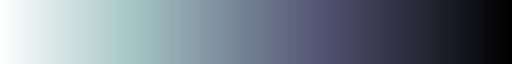

In [4]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [5]:
import time
import datetime
import argparse
from random import SystemRandom

from rich.progress import track
import tqdm

import matplotlib.pyplot as plt

import cnn_utils as cu

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Filter out runs which arrive very late.

In [10]:
arr_times_data = pd.read_csv("./data_surrogate/UShift_CME3_120runs.csv")
arr_times_data = arr_times_data.dropna()

print(arr_times_data.iloc[5, :])
print(arr_times_data.iloc[9, :])
print(arr_times_data.iloc[10, :])

# arr_times_data.head()
# arr_times_data.index[5]

arr_times_data.drop([arr_times_data.index[5],
                     arr_times_data.index[9],
                     arr_times_data.index[10]], inplace=True)

arr_times_data.head(15)

SIMID          9.0
shift        -36.0
Tshock_sim    88.0
Tshock_obs    52.0
Name: 8, dtype: float64
SIMID         13.0
shift        -34.0
Tshock_sim    86.0
Tshock_obs    52.0
Name: 12, dtype: float64
SIMID         15.0
shift        -37.0
Tshock_sim    89.0
Tshock_obs    52.0
Name: 14, dtype: float64


,SIMID,shift,Tshock_sim,Tshock_obs
0,1,-18.0,70.0,52
2,3,-15.0,67.0,52
3,4,-7.0,59.0,52
4,5,-22.0,74.0,52
6,7,-4.0,56.0,52
9,10,-7.0,59.0,52
10,11,-33.0,85.0,52
11,12,-21.0,73.0,52
15,16,0.0,52.0,52
16,17,-1.0,53.0,52


In [11]:
data_sim_ids = arr_times_data['SIMID'].to_numpy()
data_arr_time = arr_times_data['Tshock_sim'].to_numpy()
data_shifts = arr_times_data['shift'].to_numpy()

In [12]:
# First split sim_ids, and arr_time into train and test.
# Based on this load param file for sims and index that

In [13]:
num_sim = len(data_sim_ids)
print(num_sim)

# train_size = np.int64(num_sim * 0.6)
# valid_size = np.int64(num_sim * 0.2)
# test_size = num_sim - train_size - valid_size
# print(train_size, valid_size, test_size)

train_frac, valid_frac, test_frac = 0.6, 0.15, 0.25

110


In [14]:
generator1 = torch.Generator().manual_seed(2024)
train_valid_test = random_split(data_sim_ids, 
                                [train_frac, valid_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)


In [15]:
data_sim_ids

array([  1,   3,   4,   5,   7,  10,  11,  12,  16,  17,  18,  19,  20,
        21,  23,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120])

In [16]:
train_idx = np.array(train_valid_test[0].indices)
valid_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [17]:
train_sims = data_sim_ids[train_idx] - 1
val_sims = data_sim_ids[valid_idx] - 1
test_sims = data_sim_ids[test_idx] - 1

In [18]:
train_idx

array([ 22, 105,  30,  74,  51,  10,  76, 106, 103,  31,  87,  84,  61,
        35,  80,  33,  97,  12,   8,  45,  37,  18,  48,   2,   9,   6,
        85,  50,  79,  55, 100,  65,  13,  47,   0,   7,  60,  32,  19,
        90,  98,  92,  44,  95,  29,  23, 107,  17,  78,  94,  99,  36,
        14,  52,   3,  20, 108,  62,  75,  54,  11,  24,  57,   4,  16,
        72,  27])

In [19]:
ntrain = train_idx.shape[0]
nval = valid_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(67, 16, 27)

In [20]:
all_idx = np.concatenate((train_idx, valid_idx, test_idx), axis=0)

In [21]:
all_idx.min(), all_idx.max()

(0, 109)

In [22]:
data_arr_time.shape

(110,)

In [23]:
data_arr_time

array([70., 67., 59., 74., 56., 59., 85., 73., 52., 53., 78., 69., 67.,
       55., 61., 54., 59., 74., 71., 67., 51., 73., 56., 63., 51., 77.,
       62., 63., 72., 51., 49., 50., 74., 46., 71., 55., 61., 55., 67.,
       46., 65., 69., 56., 54., 51., 53., 64., 49., 44., 56., 50., 55.,
       47., 54., 73., 46., 43., 53., 66., 44., 38., 45., 54., 46., 46.,
       58., 50., 53., 47., 56., 43., 52., 39., 50., 63., 55., 40., 41.,
       56., 44., 38., 47., 62., 41., 40., 47., 38., 58., 39., 44., 37.,
       45., 49., 42., 39., 47., 35., 42., 33., 40., 40., 41., 36., 40.,
       41., 45., 33., 36., 47., 32.])

In [24]:
from netCDF4 import Dataset
from pathlib import Path

In [25]:
fileID = Dataset("./data_surrogate/CR2192_manuscript_validation_120runs_20240513.nc")
# print(fileID.variables)

# only access sims available in the arrival time dataframe.

UxSim = fileID.variables['UxSim'][:].T.data[:, data_sim_ids - 1]
UySim = fileID.variables['UySim'][:].T.data[:, data_sim_ids - 1]
UzSim = fileID.variables['UzSim'][:].T.data[:, data_sim_ids - 1]

USim = np.sqrt(UxSim**2 + UySim**2 + UzSim**2)

BxSim = fileID.variables['BxSim'][:].T.data[:, data_sim_ids - 1]
BySim = fileID.variables['BySim'][:].T.data[:, data_sim_ids - 1]
BzSim = fileID.variables['BzSim'][:].T.data[:, data_sim_ids - 1]

BSim = np.sqrt(BxSim**2 + BySim**2 + BzSim**2)

NpSim = fileID.variables['NpSim'][:].T.data[:, data_sim_ids - 1]

timeSim = fileID.variables['time'][:].data

# # access attribute
# # startTimeSim = fileID.attributes['startTime']
# for name, variable in fileID.variables.items():
#     for attrname in variable.ncattrs():
#         print(attrname, ':', getattr(variable, attrname))

In [26]:
USim.shape, BSim.shape, NpSim.shape, timeSim.shape

((95, 110), (95, 110), (95, 110), (95,))

In [27]:
# convert timeSim to datetime
from datetime import datetime, timedelta

# add timeSim hours to "2017_07_14T02:55:00"
start_time = datetime.strptime("2017_07_14T02:55:00", "%Y_%m_%dT%H:%M:%S")

timedelta(hours=1)

all_times = [start_time + timedelta(hours=int(hr)) for hr in timeSim]
# all_times

In [28]:
# find time index closest to arr_time
arr_time = datetime.strptime("2017_07_16T16:00:00", "%Y_%m_%dT%H:%M:%S")

arr_time_idx = np.abs(np.array(all_times) - arr_time).argmin()
np.array(all_times)[arr_time_idx]

datetime.datetime(2017, 7, 16, 15, 55)

In [29]:
# use shift data to find the time index for individual sims

shifts_data = arr_times_data['shift'].to_numpy().astype(int)

shifts_data
sim_arr_times_idx = np.array([arr_time_idx - shift for shift in shifts_data])

In [30]:
sim_arr_times_idx.shape

(110,)

In [31]:
# extract USim, BSim, NpSim for each sim at respective arr_time_idx

USim_target = np.array([USim[sim_arr_times_idx[i], i] for i in range(num_sim)])
BSim_target = np.array([BSim[sim_arr_times_idx[i], i] for i in range(num_sim)])
NpSim_target = np.array([NpSim[sim_arr_times_idx[i], i] for i in range(num_sim)])

USim_target.shape, BSim_target.shape, NpSim_target.shape

((110,), (110,), (110,))

(array([ 9., 12., 18., 21., 24., 15.,  5.,  2.,  1.,  3.]),
 array([ 0.53035042,  6.66182223, 12.79329404, 18.92476586, 25.05623767,
        31.18770949, 37.3191813 , 43.45065311, 49.58212493, 55.71359674,
        61.84506855]),
 <BarContainer object of 10 artists>)

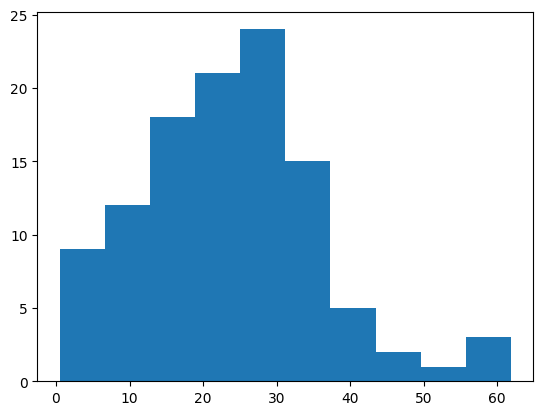

In [32]:
plt.hist(BSim_target)

(array([27., 31., 20., 13., 10.,  3.,  1.,  1.,  2.,  2.]),
 array([  6.47185629,  17.16586826,  27.85988024,  38.55389222,
         49.24790419,  59.94191617,  70.63592814,  81.32994012,
         92.0239521 , 102.71796407, 113.41197605]),
 <BarContainer object of 10 artists>)

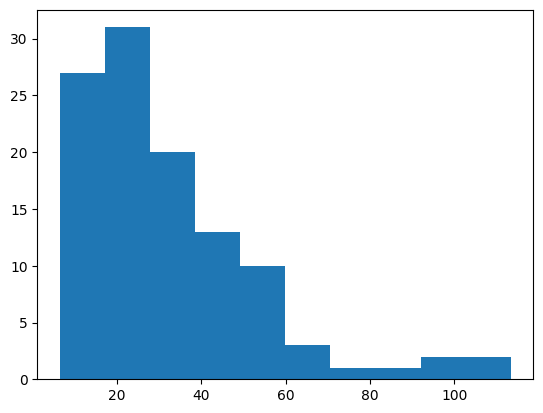

In [33]:
plt.hist(NpSim_target)

In [34]:
# stack data_arr_time, USim_target, BSim_target, NpSim_target into a single array.

target_data = np.stack((data_arr_time, 
                        # USim_target, 
                        BSim_target, 
                        # NpSim_target
                        ), axis=1)

target_data.shape

(110, 2)

In [35]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1



# scale time appropriately
tt_raw = np.linspace(all_timesteps[tMinIdx], all_timesteps[tMaxIdx], nTimesteps)
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

nTimesteps, tt_raw

(40,
 array([102., 104., 106., 108., 110., 112., 114., 116., 118., 120., 122.,
        124., 126., 128., 130., 132., 134., 136., 138., 140., 142., 144.,
        146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180.]))

In [36]:
import sklearn
import copy
train_arr_raw = target_data[train_idx, :]
val_arr_raw = target_data[valid_idx, :]
test_arr_raw = target_data[test_idx, :]

print(train_arr_raw.shape, val_arr_raw.shape, test_arr_raw.shape)

# pt = PowerTransformer(method='box-cox')
# pt = sklearn.preprocessing.RobustScaler()
pt = sklearn.preprocessing.MinMaxScaler()
pt.fit(train_arr_raw)

train_arr_pt = pt.transform(train_arr_raw)
val_arr_pt = pt.transform(val_arr_raw)
test_arr_pt = pt.transform(test_arr_raw)

(67, 2) (16, 2) (27, 2)


In [37]:
raw_datafile = np.load("./data_surrogate/CR2192_120runs_C3_ratio_PolarTensor.npy")

In [38]:
raw_datafile.shape

(128, 512, 90, 120)

In [39]:
raw_min, raw_max = raw_datafile.min(), raw_datafile.max()
raw_min, raw_max

(0.799298967364635, 1.5)

In [40]:
train_data_raw = raw_datafile[:, :, :, train_sims]
val_data_raw = raw_datafile[:, :, :, val_sims]
test_data_raw = raw_datafile[:, :, :, test_sims]

In [41]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))
    
val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [42]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.8940))

In [43]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [44]:
train_data.shape, val_data.shape, test_data.shape

(torch.Size([67, 40, 16, 64]),
 torch.Size([16, 40, 16, 64]),
 torch.Size([27, 40, 16, 64]))

In [45]:
train_data.max(), val_data.max(), test_data.max()

(tensor(1.), tensor(1.), tensor(1.))

### Concatenate parameters (optional)

In [46]:
raw_params = pd.read_csv("./data_surrogate/params_2192_120runs.csv")
raw_params = raw_params[["BStrength", "OrientationCme", "ApexHeight", "iHelicity"]]
raw_params

,BStrength,OrientationCme,ApexHeight,iHelicity
0,5.0417,347.475,0.8505,-1
1,5.1250,330.225,0.7196,1
2,6.7917,380.475,0.7482,1
3,5.3750,342.225,0.9123,-1
4,5.2917,322.725,0.8719,1
...,...,...,...,...
115,14.6250,300.225,0.6911,1
116,14.7083,371.475,0.9337,1
117,14.7917,348.225,0.7743,1
118,14.8750,312.975,0.7363,-1


In [47]:
raw_params.agg(['min', 'max'])

,BStrength,OrientationCme,ApexHeight,iHelicity
min,5.0417,294.975,0.6673,-1
max,14.9583,384.225,0.9504,1


In [48]:
raw_params_retained = raw_params.to_numpy()[data_sim_ids - 1, :]
raw_params_retained.shape

(110, 4)

In [50]:
param_scaling = [15, 384, 0.95, 1]

In [51]:
raw_params_retained[train_idx, :].shape

(67, 4)

### Train-test split and normalization

Use train_idx, valid_idx and test_idx

In [52]:
train_params_raw = raw_params_retained[train_idx, :] / param_scaling
valid_params_raw = raw_params_retained[valid_idx, :] / param_scaling
test_params_raw = raw_params_retained[test_idx, :] / param_scaling

In [53]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [54]:
train_snaps.shape, val_snaps.shape

(torch.Size([67, 40, 1024]), torch.Size([16, 40, 1024]))

In [55]:
train_arr_ts = torch.Tensor(train_arr_pt)
val_arr_ts = torch.Tensor(val_arr_pt)
test_arr_ts = torch.Tensor(test_arr_pt)

train_arr_raw_ts = torch.Tensor(train_arr_raw).unsqueeze(1)
val_arr_raw_ts = torch.Tensor(val_arr_raw).unsqueeze(1)
test_arr_raw_ts = torch.Tensor(test_arr_raw).unsqueeze(1)

In [56]:
train_all.shape, val_all.shape, test_all.shape

(torch.Size([67, 40, 1028]),
 torch.Size([16, 40, 1028]),
 torch.Size([27, 40, 1028]))

In [57]:
ntrain, nval, ntest

(67, 16, 27)

In [58]:
train_dataset = []
val_dataset = []
test_dataset = []
for i in range(ntrain):
    for j in range(1, nTimesteps - 1):
        train_dataset.append((train_all[i:(i+1), (j-1):(j+2), :], train_arr_ts[i, :], train_arr_raw_ts[i, :]))

for i in range(nval):
    for j in range(1, nTimesteps - 1):
        val_dataset.append((val_all[i:(i+1), (j-1):(j+2), :], val_arr_ts[i, :], val_arr_raw_ts[i, :]))

for i in range(ntest):
    for j in range(1, nTimesteps - 1):
        test_dataset.append((test_all[i:(i+1), (j-1):(j+2), :], test_arr_ts[i, :], test_arr_raw_ts[i, :]))

In [59]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = args["batch_size"],
                              shuffle=True, 
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size = args["batch_size"],
                            shuffle=False,
                            )

test_dataloader = DataLoader(test_dataset,
                             batch_size = len(test_dataset),
                             shuffle=False,
                             )

In [60]:
test_all.shape

torch.Size([27, 40, 1028])

In [61]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2546, 608, 1026)

In [62]:
# blah = train_dataloader.__iter__().__next__()
# blah[0].shape, blah[1].shape, blah[2].shape

In [63]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

In [66]:
class WLCNN_Discrete(torch.nn.Module):
    def __init__(self, n_hidden_1,
                  n_hidden_2):
        super(WLCNN_Discrete, self).__init__()
        in_channels = 3

        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=3),
            nn.BatchNorm2d(16),
            nn.ELU(),
            # nn.ELU(),
            # nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.regressor = torch.nn.Sequential(
            # nn.Linear(1280, n_hidden_1),
            nn.Linear(1284, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(n_hidden_2, 2)
        )

    def forward(self, x):
        x_ip = x[:, 0, :, :1024].reshape(-1, 3, 16, 64)
        x_param = x[:, 0, 0, 1024:]
        
        x_ft = self.features(x_ip)
        
        x_ft = torch.flatten(x_ft, 1)

        x_ft_cat = torch.cat((x_ft, x_param), 1)
        # xpred = self.regressor(x_ft)
        xpred = self.regressor(x_ft_cat)

        return xpred

In [67]:
import node_utils as nut
import data_utils as dut
import copy

In [68]:
model = WLCNN_Discrete(n_hidden_1=16,
                       n_hidden_2=8).to(device)
pmodel = nut.count_parameters(model)


print("Total number of parameters for model with concatenation: ", pmodel)

nut.makedirs(os.path.join(os.getcwd(), "arr_logs"))
logdir = os.path.join(os.getcwd(), "arr_logs")

exptdir = os.path.join(os.getcwd(), args["save"])
nut.makedirs(exptdir)

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"]==True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random() * 1e5)
        print("Starting New experiment")

print("Experiment ID: ", experimentID)

ckpt_path = ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint path: ", ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "experiment_" + str(experimentID) + '.log'))

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pmodel))
logger.info(args)
logger.info(ckpt_path)
logger.info(device)

Total number of parameters for model with concatenation:  24250
Starting New experiment
Experiment ID:  50967
Checkpoint path:  /Users/ajivani/Desktop/Research/WLROM/WhiteLight/arr_experiments/experiment_50967.ckpt
/Users/ajivani/Desktop/Research/WLROM/WhiteLight
WLCNN_Discrete(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=1284, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=

In [69]:
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
if args["loss"] == "smooth_l1":
    criterion = nn.SmoothL1Loss().to(device)
elif args["loss"] == "mae":
    criterion = nn.L1Loss().to(device)
elif args["loss"] == "mse":
    criterion = nn.MSELoss().to(device)

# criterion = InverseBoxCoxLoss(pt)

print(criterion)
early_stopping = nut.EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
N_EPOCHS = args["niters"]

num_batches = 1
all_train_loss = []
all_valid_loss = []
ckpt_freq = 10
if args["load"] is None:
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))

    # Resume training from specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over epochs..."):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        optimizer.zero_grad()

        for i, (raw_img, arr_target_scaled, arr_target) in enumerate(train_dataloader):
            raw_img = raw_img.to(device)
            # arr_target = arr_target.to(device)
            arr_target = arr_target_scaled.to(device)

            # Forward pass
            arr_pred = model(raw_img)

            # Compute Loss
            loss = criterion(arr_pred, arr_target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for i, (raw_img_val, arr_target_val_scaled, arr_target_val) in enumerate(val_dataloader):
                raw_img_val = raw_img_val.to(device)
                # arr_target_val = arr_target_val.to(device)
                arr_target_val = arr_target_val_scaled.to(device)

                # Forward pass
                arr_pred_val = model(raw_img_val)

                val_loss = criterion(arr_pred_val, arr_target_val)

                valid_loss += val_loss.item()

        train_loss = train_loss / len(train_dataloader)
        valid_loss = valid_loss / len(val_dataloader)

        all_train_loss.append(train_loss)
        all_valid_loss.append(valid_loss)


        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        valid_loss,
                        train_loss,
                        optimizer.param_groups[0]["lr"])
        
        logger.info(message)
        scheduler.step(valid_loss)

        if itr % ckpt_freq == 0:
            early_stopping(val_loss, all_valid_loss, all_train_loss, model, optimizer, itr, args)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            torch.save({'epoch': itr,
                    'model': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'all_train_loss': all_train_loss,
                    'all_valid_loss': all_valid_loss,
                    'args': args},
                    os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt"))
            break
else:
    # check if early stopped model is available!
    early_stop_filepath = os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt")

    if os.path.exists(early_stop_filepath):
        if args["load"] == 56:
            early_stp_ckpt = torch.load(early_stop_filepath)
            model.load_state_dict(early_stp_ckpt)
        else:
            nut.get_ckpt_model(early_stop_filepath, model, optimizer, device)
        print("Loading early stopped model ID {} from {}".format(experimentID, early_stop_filepath))
    else:
        nut.get_ckpt_model(ckpt_path, model, optimizer, device)
        print("Loading existing model ID {} from {}".format(experimentID, ckpt_path))

Output()

L1Loss()
Starting a new experiment 50967 from Epoch 0


Epoch 0001|Val loss 1.820142e-01|Train loss 3.507789e-01|LR 0.00100|

Epoch 0002|Val loss 1.389549e-01|Train loss 2.307990e-01|LR 0.00100|

Epoch 0003|Val loss 1.217088e-01|Train loss 1.825922e-01|LR 0.00100|

Epoch 0004|Val loss 1.481971e-01|Train loss 1.724718e-01|LR 0.00100|

Epoch 0005|Val loss 1.128965e-01|Train loss 1.584614e-01|LR 0.00100|

Epoch 0006|Val loss 9.520306e-02|Train loss 1.486409e-01|LR 0.00100|

Epoch 0007|Val loss 1.150157e-01|Train loss 1.457559e-01|LR 0.00100|

Epoch 0008|Val loss 8.917305e-02|Train loss 1.384204e-01|LR 0.00100|

Epoch 0009|Val loss 1.332436e-01|Train loss 1.385650e-01|LR 0.00100|

Epoch 0010|Val loss 2.936040e-01|Train loss 1.367414e-01|LR 0.00100|

Val loss decreased (inf to 0.29). Model saved

Epoch 0011|Val loss 1.419477e-01|Train loss 1.372503e-01|LR 0.00100|

Epoch 0012|Val loss 1.181208e-01|Train loss 1.377434e-01|LR 0.00100|

Epoch 0013|Val loss 8.997354e-02|Train loss 1.396151e-01|LR 0.00100|

Epoch 0014|Val loss 1.002796e-01|Train loss 1.386730e-01|LR 0.00100|

Epoch 0015|Val loss 1.007714e-01|Train loss 1.317088e-01|LR 0.00100|

Epoch 0016|Val loss 1.076239e-01|Train loss 1.339093e-01|LR 0.00100|

Epoch 0017|Val loss 1.104525e-01|Train loss 1.324140e-01|LR 0.00100|

Epoch 0018|Val loss 1.826563e-01|Train loss 1.312436e-01|LR 0.00100|

Epoch 0019|Val loss 1.019384e-01|Train loss 1.305174e-01|LR 0.00100|

Epoch 0020|Val loss 1.093359e-01|Train loss 1.324743e-01|LR 0.00100|

Val loss decreased (0.29 to 0.11). Model saved

Epoch 0021|Val loss 1.703366e-01|Train loss 1.405848e-01|LR 0.00100|

Epoch 0022|Val loss 1.061801e-01|Train loss 1.418794e-01|LR 0.00100|

Epoch 0023|Val loss 1.184743e-01|Train loss 1.403138e-01|LR 0.00100|

Epoch 0024|Val loss 9.978419e-02|Train loss 1.328117e-01|LR 0.00100|

Epoch 0025|Val loss 2.008215e-01|Train loss 1.360930e-01|LR 0.00100|

Epoch 0026|Val loss 2.502767e-01|Train loss 1.402711e-01|LR 0.00100|

Epoch 0027|Val loss 1.317903e-01|Train loss 1.395783e-01|LR 0.00100|

Epoch 0028|Val loss 1.326270e-01|Train loss 1.439219e-01|LR 0.00100|

Epoch 0029|Val loss 1.272437e-01|Train loss 1.490291e-01|LR 0.00100|

Epoch 0030|Val loss 1.023657e-01|Train loss 1.460956e-01|LR 0.00100|

Val loss decreased (0.11 to 0.10). Model saved

Epoch 0031|Val loss 1.293573e-01|Train loss 1.446991e-01|LR 0.00100|

Epoch 0032|Val loss 1.157962e-01|Train loss 1.470623e-01|LR 0.00100|

Epoch 0033|Val loss 1.439146e-01|Train loss 1.427277e-01|LR 0.00100|

Epoch 0034|Val loss 9.818469e-02|Train loss 1.514432e-01|LR 0.00100|

Epoch 0035|Val loss 1.245901e-01|Train loss 1.313091e-01|LR 0.00100|

Epoch 0036|Val loss 1.160190e-01|Train loss 1.332428e-01|LR 0.00100|

Epoch 0037|Val loss 1.395338e-01|Train loss 1.372698e-01|LR 0.00100|

Epoch 0038|Val loss 1.030056e-01|Train loss 1.430620e-01|LR 0.00100|

Epoch 0039|Val loss 1.333753e-01|Train loss 1.328694e-01|LR 0.00100|

Epoch 0040|Val loss 1.127293e-01|Train loss 1.378145e-01|LR 0.00100|

EarlyStopping counter: 1 out of 20

Epoch 0041|Val loss 1.208870e-01|Train loss 1.386716e-01|LR 0.00100|

Epoch 0042|Val loss 9.790748e-02|Train loss 1.389186e-01|LR 0.00100|

Epoch 0043|Val loss 1.218684e-01|Train loss 1.326557e-01|LR 0.00100|

Epoch 0044|Val loss 1.413028e-01|Train loss 1.356616e-01|LR 0.00100|

Epoch 0045|Val loss 1.283913e-01|Train loss 1.335243e-01|LR 0.00100|

Epoch 0046|Val loss 1.115402e-01|Train loss 1.351793e-01|LR 0.00100|

Epoch 0047|Val loss 1.224751e-01|Train loss 1.285718e-01|LR 0.00100|

Epoch 0048|Val loss 1.217486e-01|Train loss 1.315650e-01|LR 0.00100|

Epoch 0049|Val loss 1.309298e-01|Train loss 1.322366e-01|LR 0.00100|

Epoch 0050|Val loss 1.069347e-01|Train loss 1.373942e-01|LR 0.00060|

EarlyStopping counter: 2 out of 20

Epoch 0051|Val loss 9.296100e-02|Train loss 1.262935e-01|LR 0.00060|

Epoch 0052|Val loss 9.350420e-02|Train loss 1.250046e-01|LR 0.00060|

Epoch 0053|Val loss 1.111903e-01|Train loss 1.295105e-01|LR 0.00060|

Epoch 0054|Val loss 1.044024e-01|Train loss 1.350829e-01|LR 0.00060|

Epoch 0055|Val loss 9.229400e-02|Train loss 1.362432e-01|LR 0.00060|

Epoch 0056|Val loss 1.092564e-01|Train loss 1.274378e-01|LR 0.00060|

Epoch 0057|Val loss 1.122684e-01|Train loss 1.250240e-01|LR 0.00060|

Epoch 0058|Val loss 1.043214e-01|Train loss 1.243396e-01|LR 0.00060|

Epoch 0059|Val loss 9.673769e-02|Train loss 1.239766e-01|LR 0.00060|

Epoch 0060|Val loss 1.441508e-01|Train loss 1.259597e-01|LR 0.00060|

EarlyStopping counter: 3 out of 20

Epoch 0061|Val loss 1.565815e-01|Train loss 1.261652e-01|LR 0.00060|

Epoch 0062|Val loss 1.242747e-01|Train loss 1.294308e-01|LR 0.00060|

Epoch 0063|Val loss 9.549905e-02|Train loss 1.293794e-01|LR 0.00060|

Epoch 0064|Val loss 1.401569e-01|Train loss 1.296764e-01|LR 0.00060|

Epoch 0065|Val loss 1.634850e-01|Train loss 1.302318e-01|LR 0.00060|

Epoch 0066|Val loss 1.254357e-01|Train loss 1.290952e-01|LR 0.00060|

Epoch 0067|Val loss 8.814727e-02|Train loss 1.307154e-01|LR 0.00060|

Epoch 0068|Val loss 1.234703e-01|Train loss 1.259727e-01|LR 0.00060|

Epoch 0069|Val loss 1.412412e-01|Train loss 1.248486e-01|LR 0.00060|

Epoch 0070|Val loss 1.085511e-01|Train loss 1.270479e-01|LR 0.00060|

EarlyStopping counter: 4 out of 20

Epoch 0071|Val loss 8.625838e-02|Train loss 1.264052e-01|LR 0.00060|

Epoch 0072|Val loss 1.062376e-01|Train loss 1.274210e-01|LR 0.00060|

Epoch 0073|Val loss 9.071003e-02|Train loss 1.279985e-01|LR 0.00060|

Epoch 0074|Val loss 1.203099e-01|Train loss 1.266547e-01|LR 0.00060|

Epoch 0075|Val loss 1.585480e-01|Train loss 1.269535e-01|LR 0.00060|

Epoch 0076|Val loss 9.878604e-02|Train loss 1.272066e-01|LR 0.00060|

Epoch 0077|Val loss 9.992246e-02|Train loss 1.265621e-01|LR 0.00060|

Epoch 0078|Val loss 1.179360e-01|Train loss 1.273137e-01|LR 0.00060|

Epoch 0079|Val loss 8.754641e-02|Train loss 1.245618e-01|LR 0.00060|

Epoch 0080|Val loss 9.822504e-02|Train loss 1.254345e-01|LR 0.00060|

Val loss decreased (0.10 to 0.10). Model saved

Epoch 0081|Val loss 1.061459e-01|Train loss 1.243199e-01|LR 0.00060|

Epoch 0082|Val loss 1.562679e-01|Train loss 1.256053e-01|LR 0.00060|

Epoch 0083|Val loss 1.736845e-01|Train loss 1.253870e-01|LR 0.00060|

Epoch 0084|Val loss 1.130669e-01|Train loss 1.245319e-01|LR 0.00060|

Epoch 0085|Val loss 8.447037e-02|Train loss 1.245811e-01|LR 0.00060|

Epoch 0086|Val loss 1.112774e-01|Train loss 1.256360e-01|LR 0.00060|

Epoch 0087|Val loss 9.730600e-02|Train loss 1.257633e-01|LR 0.00060|

Epoch 0088|Val loss 1.220829e-01|Train loss 1.315722e-01|LR 0.00060|

Epoch 0089|Val loss 1.561307e-01|Train loss 1.346057e-01|LR 0.00060|

Epoch 0090|Val loss 1.140117e-01|Train loss 1.306675e-01|LR 0.00060|

EarlyStopping counter: 1 out of 20

Epoch 0091|Val loss 1.166040e-01|Train loss 1.288787e-01|LR 0.00060|

Epoch 0092|Val loss 1.052650e-01|Train loss 1.272324e-01|LR 0.00060|

Epoch 0093|Val loss 1.294315e-01|Train loss 1.260285e-01|LR 0.00060|

Epoch 0094|Val loss 1.104823e-01|Train loss 1.242992e-01|LR 0.00060|

Epoch 0095|Val loss 1.055622e-01|Train loss 1.255765e-01|LR 0.00060|

Epoch 0096|Val loss 8.930286e-02|Train loss 1.247359e-01|LR 0.00060|

Epoch 0097|Val loss 1.065269e-01|Train loss 1.270115e-01|LR 0.00060|

Epoch 0098|Val loss 9.228512e-02|Train loss 1.278372e-01|LR 0.00060|

Epoch 0099|Val loss 9.709771e-02|Train loss 1.282434e-01|LR 0.00060|

Epoch 0100|Val loss 1.037053e-01|Train loss 1.285967e-01|LR 0.00060|

EarlyStopping counter: 2 out of 20

Epoch 0101|Val loss 1.028731e-01|Train loss 1.282706e-01|LR 0.00060|

Epoch 0102|Val loss 1.023351e-01|Train loss 1.267314e-01|LR 0.00060|

Epoch 0103|Val loss 1.074559e-01|Train loss 1.282835e-01|LR 0.00060|

Epoch 0104|Val loss 9.354909e-02|Train loss 1.265446e-01|LR 0.00060|

Epoch 0105|Val loss 1.266932e-01|Train loss 1.302219e-01|LR 0.00060|

Epoch 0106|Val loss 1.331484e-01|Train loss 1.311736e-01|LR 0.00060|

Epoch 0107|Val loss 1.175243e-01|Train loss 1.269629e-01|LR 0.00060|

Epoch 0108|Val loss 9.005327e-02|Train loss 1.266643e-01|LR 0.00060|

Epoch 0109|Val loss 1.319607e-01|Train loss 1.239851e-01|LR 0.00060|

Epoch 0110|Val loss 1.182711e-01|Train loss 1.248686e-01|LR 0.00060|

EarlyStopping counter: 3 out of 20

Epoch 0111|Val loss 1.134183e-01|Train loss 1.268123e-01|LR 0.00060|

Epoch 0112|Val loss 9.072711e-02|Train loss 1.247901e-01|LR 0.00060|

Epoch 0113|Val loss 1.058382e-01|Train loss 1.269586e-01|LR 0.00060|

Epoch 0114|Val loss 9.111123e-02|Train loss 1.267435e-01|LR 0.00060|

Epoch 0115|Val loss 1.152206e-01|Train loss 1.262474e-01|LR 0.00060|

Epoch 0116|Val loss 1.176443e-01|Train loss 1.296681e-01|LR 0.00060|

Epoch 0117|Val loss 1.198045e-01|Train loss 1.298207e-01|LR 0.00060|

Epoch 0118|Val loss 9.051828e-02|Train loss 1.310714e-01|LR 0.00060|

Epoch 0119|Val loss 1.050635e-01|Train loss 1.309166e-01|LR 0.00060|

Epoch 0120|Val loss 1.051430e-01|Train loss 1.294870e-01|LR 0.00060|

EarlyStopping counter: 4 out of 20

Epoch 0121|Val loss 9.558485e-02|Train loss 1.246441e-01|LR 0.00060|

Epoch 0122|Val loss 9.044191e-02|Train loss 1.261391e-01|LR 0.00060|

Epoch 0123|Val loss 1.055957e-01|Train loss 1.266275e-01|LR 0.00060|

Epoch 0124|Val loss 1.253501e-01|Train loss 1.260148e-01|LR 0.00060|

Epoch 0125|Val loss 1.164795e-01|Train loss 1.247470e-01|LR 0.00060|

Epoch 0126|Val loss 1.188684e-01|Train loss 1.258915e-01|LR 0.00060|

Epoch 0127|Val loss 1.018852e-01|Train loss 1.237051e-01|LR 0.00036|

Epoch 0128|Val loss 8.941673e-02|Train loss 1.199282e-01|LR 0.00036|

Epoch 0129|Val loss 9.478925e-02|Train loss 1.211538e-01|LR 0.00036|

Epoch 0130|Val loss 8.432381e-02|Train loss 1.200665e-01|LR 0.00036|

Val loss decreased (0.10 to 0.08). Model saved

Epoch 0131|Val loss 9.070899e-02|Train loss 1.197494e-01|LR 0.00036|

Epoch 0132|Val loss 8.953863e-02|Train loss 1.198312e-01|LR 0.00036|

Epoch 0133|Val loss 9.707864e-02|Train loss 1.195690e-01|LR 0.00036|

Epoch 0134|Val loss 1.093133e-01|Train loss 1.209403e-01|LR 0.00036|

Epoch 0135|Val loss 1.130659e-01|Train loss 1.205820e-01|LR 0.00036|

Epoch 0136|Val loss 1.023558e-01|Train loss 1.209278e-01|LR 0.00036|

Epoch 0137|Val loss 8.906233e-02|Train loss 1.218312e-01|LR 0.00036|

Epoch 0138|Val loss 1.135162e-01|Train loss 1.222623e-01|LR 0.00036|

Epoch 0139|Val loss 1.151004e-01|Train loss 1.226486e-01|LR 0.00036|

Epoch 0140|Val loss 1.080783e-01|Train loss 1.245355e-01|LR 0.00036|

EarlyStopping counter: 1 out of 20

Epoch 0141|Val loss 8.626457e-02|Train loss 1.229115e-01|LR 0.00036|

Epoch 0142|Val loss 1.008267e-01|Train loss 1.211747e-01|LR 0.00036|

Epoch 0143|Val loss 8.525727e-02|Train loss 1.231128e-01|LR 0.00036|

Epoch 0144|Val loss 9.655798e-02|Train loss 1.225811e-01|LR 0.00036|

Epoch 0145|Val loss 8.285931e-02|Train loss 1.235974e-01|LR 0.00036|

Epoch 0146|Val loss 9.580063e-02|Train loss 1.220574e-01|LR 0.00036|

Epoch 0147|Val loss 9.704469e-02|Train loss 1.222602e-01|LR 0.00036|

Epoch 0148|Val loss 9.466330e-02|Train loss 1.228308e-01|LR 0.00036|

Epoch 0149|Val loss 8.568537e-02|Train loss 1.208886e-01|LR 0.00036|

Epoch 0150|Val loss 1.017841e-01|Train loss 1.240197e-01|LR 0.00036|

EarlyStopping counter: 2 out of 20

Epoch 0151|Val loss 1.042211e-01|Train loss 1.243882e-01|LR 0.00036|

Epoch 0152|Val loss 1.002455e-01|Train loss 1.240101e-01|LR 0.00036|

Epoch 0153|Val loss 8.638837e-02|Train loss 1.237685e-01|LR 0.00036|

Epoch 0154|Val loss 1.047578e-01|Train loss 1.228032e-01|LR 0.00036|

Epoch 0155|Val loss 9.107267e-02|Train loss 1.232730e-01|LR 0.00036|

Epoch 0156|Val loss 1.015613e-01|Train loss 1.214487e-01|LR 0.00036|

Epoch 0157|Val loss 1.089392e-01|Train loss 1.237515e-01|LR 0.00036|

Epoch 0158|Val loss 1.131497e-01|Train loss 1.211995e-01|LR 0.00036|

Epoch 0159|Val loss 1.409129e-01|Train loss 1.214097e-01|LR 0.00036|

Epoch 0160|Val loss 1.001203e-01|Train loss 1.222635e-01|LR 0.00036|

EarlyStopping counter: 3 out of 20

Epoch 0161|Val loss 9.335604e-02|Train loss 1.214843e-01|LR 0.00036|

Epoch 0162|Val loss 9.432242e-02|Train loss 1.190525e-01|LR 0.00036|

Epoch 0163|Val loss 9.281702e-02|Train loss 1.203577e-01|LR 0.00036|

Epoch 0164|Val loss 1.137927e-01|Train loss 1.211737e-01|LR 0.00036|

Epoch 0165|Val loss 8.851409e-02|Train loss 1.222063e-01|LR 0.00036|

Epoch 0166|Val loss 9.572212e-02|Train loss 1.220712e-01|LR 0.00036|

Epoch 0167|Val loss 9.084963e-02|Train loss 1.209051e-01|LR 0.00036|

Epoch 0168|Val loss 9.671462e-02|Train loss 1.211348e-01|LR 0.00036|

Epoch 0169|Val loss 8.445281e-02|Train loss 1.217068e-01|LR 0.00036|

Epoch 0170|Val loss 1.018504e-01|Train loss 1.213073e-01|LR 0.00036|

EarlyStopping counter: 4 out of 20

Epoch 0171|Val loss 9.203823e-02|Train loss 1.233548e-01|LR 0.00036|

Epoch 0172|Val loss 1.054291e-01|Train loss 1.225941e-01|LR 0.00036|

Epoch 0173|Val loss 1.085483e-01|Train loss 1.245753e-01|LR 0.00036|

Epoch 0174|Val loss 1.067956e-01|Train loss 1.235304e-01|LR 0.00036|

Epoch 0175|Val loss 9.193743e-02|Train loss 1.238145e-01|LR 0.00036|

Epoch 0176|Val loss 1.018743e-01|Train loss 1.247747e-01|LR 0.00036|

Epoch 0177|Val loss 8.992994e-02|Train loss 1.229428e-01|LR 0.00036|

Epoch 0178|Val loss 1.031124e-01|Train loss 1.242143e-01|LR 0.00036|

Epoch 0179|Val loss 8.667568e-02|Train loss 1.238561e-01|LR 0.00036|

Epoch 0180|Val loss 1.007457e-01|Train loss 1.224561e-01|LR 0.00036|

EarlyStopping counter: 5 out of 20

Epoch 0181|Val loss 1.072139e-01|Train loss 1.232978e-01|LR 0.00036|

Epoch 0182|Val loss 1.005812e-01|Train loss 1.222282e-01|LR 0.00036|

Epoch 0183|Val loss 1.175748e-01|Train loss 1.222583e-01|LR 0.00036|

Epoch 0184|Val loss 1.049221e-01|Train loss 1.221883e-01|LR 0.00036|

Epoch 0185|Val loss 9.793799e-02|Train loss 1.225668e-01|LR 0.00036|

Epoch 0186|Val loss 8.755305e-02|Train loss 1.211521e-01|LR 0.00036|

Epoch 0187|Val loss 9.826818e-02|Train loss 1.224050e-01|LR 0.00022|

Epoch 0188|Val loss 9.930202e-02|Train loss 1.191356e-01|LR 0.00022|

Epoch 0189|Val loss 9.449144e-02|Train loss 1.215396e-01|LR 0.00022|

Epoch 0190|Val loss 9.803018e-02|Train loss 1.199415e-01|LR 0.00022|

EarlyStopping counter: 6 out of 20

Epoch 0191|Val loss 9.432806e-02|Train loss 1.204557e-01|LR 0.00022|

Epoch 0192|Val loss 8.870872e-02|Train loss 1.209787e-01|LR 0.00022|

Epoch 0193|Val loss 8.642787e-02|Train loss 1.200110e-01|LR 0.00022|

Epoch 0194|Val loss 9.239763e-02|Train loss 1.184969e-01|LR 0.00022|

Epoch 0195|Val loss 9.315470e-02|Train loss 1.219312e-01|LR 0.00022|

Epoch 0196|Val loss 8.780381e-02|Train loss 1.190155e-01|LR 0.00022|

Epoch 0197|Val loss 8.441043e-02|Train loss 1.184720e-01|LR 0.00022|

Epoch 0198|Val loss 8.762732e-02|Train loss 1.182577e-01|LR 0.00022|

Epoch 0199|Val loss 8.662065e-02|Train loss 1.214860e-01|LR 0.00022|

Epoch 0200|Val loss 9.790243e-02|Train loss 1.192496e-01|LR 0.00022|

EarlyStopping counter: 7 out of 20

Epoch 0201|Val loss 8.895630e-02|Train loss 1.187739e-01|LR 0.00022|

Epoch 0202|Val loss 9.072946e-02|Train loss 1.189639e-01|LR 0.00022|

Epoch 0203|Val loss 9.219694e-02|Train loss 1.212370e-01|LR 0.00022|

Epoch 0204|Val loss 9.275755e-02|Train loss 1.193716e-01|LR 0.00022|

Epoch 0205|Val loss 8.508134e-02|Train loss 1.197369e-01|LR 0.00022|

Epoch 0206|Val loss 8.502451e-02|Train loss 1.191657e-01|LR 0.00022|

Epoch 0207|Val loss 8.691994e-02|Train loss 1.194779e-01|LR 0.00022|

Epoch 0208|Val loss 8.563615e-02|Train loss 1.222214e-01|LR 0.00022|

Epoch 0209|Val loss 1.020232e-01|Train loss 1.202906e-01|LR 0.00022|

Epoch 0210|Val loss 8.695783e-02|Train loss 1.204560e-01|LR 0.00022|

EarlyStopping counter: 8 out of 20

Epoch 0211|Val loss 8.987342e-02|Train loss 1.207812e-01|LR 0.00022|

Epoch 0212|Val loss 8.616647e-02|Train loss 1.221146e-01|LR 0.00022|

Epoch 0213|Val loss 8.480224e-02|Train loss 1.196611e-01|LR 0.00022|

Epoch 0214|Val loss 8.814085e-02|Train loss 1.193350e-01|LR 0.00022|

Epoch 0215|Val loss 9.109253e-02|Train loss 1.201549e-01|LR 0.00022|

Epoch 0216|Val loss 8.919135e-02|Train loss 1.187183e-01|LR 0.00022|

Epoch 0217|Val loss 8.683408e-02|Train loss 1.213091e-01|LR 0.00022|

Epoch 0218|Val loss 8.788216e-02|Train loss 1.204475e-01|LR 0.00022|

Epoch 0219|Val loss 9.283736e-02|Train loss 1.211572e-01|LR 0.00022|

Epoch 0220|Val loss 8.615937e-02|Train loss 1.200965e-01|LR 0.00022|

EarlyStopping counter: 9 out of 20

Epoch 0221|Val loss 9.383644e-02|Train loss 1.199498e-01|LR 0.00022|

Epoch 0222|Val loss 8.398099e-02|Train loss 1.188287e-01|LR 0.00022|

Epoch 0223|Val loss 9.103270e-02|Train loss 1.178719e-01|LR 0.00022|

Epoch 0224|Val loss 8.643370e-02|Train loss 1.167617e-01|LR 0.00022|

Epoch 0225|Val loss 9.124040e-02|Train loss 1.168436e-01|LR 0.00022|

Epoch 0226|Val loss 8.043342e-02|Train loss 1.181375e-01|LR 0.00022|

Epoch 0227|Val loss 8.331643e-02|Train loss 1.207280e-01|LR 0.00022|

Epoch 0228|Val loss 8.102067e-02|Train loss 1.167713e-01|LR 0.00022|

Epoch 0229|Val loss 8.291845e-02|Train loss 1.169582e-01|LR 0.00022|

Epoch 0230|Val loss 8.774710e-02|Train loss 1.150328e-01|LR 0.00022|

EarlyStopping counter: 10 out of 20

Epoch 0231|Val loss 7.777311e-02|Train loss 1.171450e-01|LR 0.00022|

Epoch 0232|Val loss 7.528323e-02|Train loss 1.156872e-01|LR 0.00022|

Epoch 0233|Val loss 8.643731e-02|Train loss 1.158418e-01|LR 0.00022|

Epoch 0234|Val loss 7.370785e-02|Train loss 1.130882e-01|LR 0.00022|

Epoch 0235|Val loss 6.987570e-02|Train loss 1.117690e-01|LR 0.00022|

Epoch 0236|Val loss 7.698010e-02|Train loss 1.116582e-01|LR 0.00022|

Epoch 0237|Val loss 8.009108e-02|Train loss 1.134574e-01|LR 0.00022|

Epoch 0238|Val loss 8.009865e-02|Train loss 1.150065e-01|LR 0.00022|

Epoch 0239|Val loss 7.441907e-02|Train loss 1.143332e-01|LR 0.00022|

Epoch 0240|Val loss 7.608026e-02|Train loss 1.120406e-01|LR 0.00022|

Val loss decreased (0.08 to 0.08). Model saved

Epoch 0241|Val loss 7.153077e-02|Train loss 1.124974e-01|LR 0.00022|

Epoch 0242|Val loss 7.631310e-02|Train loss 1.122857e-01|LR 0.00022|

Epoch 0243|Val loss 7.605876e-02|Train loss 1.128506e-01|LR 0.00022|

Epoch 0244|Val loss 7.324904e-02|Train loss 1.120938e-01|LR 0.00022|

Epoch 0245|Val loss 7.195181e-02|Train loss 1.079443e-01|LR 0.00022|

Epoch 0246|Val loss 7.870822e-02|Train loss 1.094060e-01|LR 0.00022|

Epoch 0247|Val loss 7.882759e-02|Train loss 1.123383e-01|LR 0.00022|

Epoch 0248|Val loss 6.942821e-02|Train loss 1.137873e-01|LR 0.00022|

Epoch 0249|Val loss 7.628716e-02|Train loss 1.137211e-01|LR 0.00022|

Epoch 0250|Val loss 6.941539e-02|Train loss 1.109851e-01|LR 0.00022|

Val loss decreased (0.08 to 0.07). Model saved

Epoch 0251|Val loss 7.856779e-02|Train loss 1.119755e-01|LR 0.00022|

Epoch 0252|Val loss 7.298602e-02|Train loss 1.102841e-01|LR 0.00022|

Epoch 0253|Val loss 7.219441e-02|Train loss 1.082379e-01|LR 0.00022|

Epoch 0254|Val loss 7.538709e-02|Train loss 1.105965e-01|LR 0.00022|

Epoch 0255|Val loss 7.259134e-02|Train loss 1.076240e-01|LR 0.00022|

Epoch 0256|Val loss 7.530944e-02|Train loss 1.078187e-01|LR 0.00022|

Epoch 0257|Val loss 7.171312e-02|Train loss 1.109071e-01|LR 0.00022|

Epoch 0258|Val loss 7.846040e-02|Train loss 1.089832e-01|LR 0.00022|

Epoch 0259|Val loss 7.252484e-02|Train loss 1.100975e-01|LR 0.00022|

Epoch 0260|Val loss 7.571429e-02|Train loss 1.096419e-01|LR 0.00022|

EarlyStopping counter: 1 out of 20

Epoch 0261|Val loss 7.765682e-02|Train loss 1.100557e-01|LR 0.00022|

Epoch 0262|Val loss 8.411673e-02|Train loss 1.093327e-01|LR 0.00022|

Epoch 0263|Val loss 8.698104e-02|Train loss 1.103661e-01|LR 0.00022|

Epoch 0264|Val loss 1.070309e-01|Train loss 1.089933e-01|LR 0.00022|

Epoch 0265|Val loss 7.933790e-02|Train loss 1.064606e-01|LR 0.00022|

Epoch 0266|Val loss 7.691216e-02|Train loss 1.068809e-01|LR 0.00022|

Epoch 0267|Val loss 6.550469e-02|Train loss 1.089787e-01|LR 0.00022|

Epoch 0268|Val loss 7.660784e-02|Train loss 1.079113e-01|LR 0.00022|

Epoch 0269|Val loss 6.794145e-02|Train loss 1.074256e-01|LR 0.00022|

Epoch 0270|Val loss 8.073946e-02|Train loss 1.090414e-01|LR 0.00022|

Epoch 0271|Val loss 6.884320e-02|Train loss 1.083005e-01|LR 0.00022|

Epoch 0272|Val loss 8.138680e-02|Train loss 1.083088e-01|LR 0.00022|

Epoch 0273|Val loss 7.837185e-02|Train loss 1.068821e-01|LR 0.00022|

Epoch 0274|Val loss 8.208936e-02|Train loss 1.056410e-01|LR 0.00022|

Epoch 0275|Val loss 7.458095e-02|Train loss 1.106526e-01|LR 0.00022|

Epoch 0276|Val loss 7.653625e-02|Train loss 1.063884e-01|LR 0.00022|

Epoch 0277|Val loss 6.797398e-02|Train loss 1.070517e-01|LR 0.00022|

Epoch 0278|Val loss 7.735117e-02|Train loss 1.073565e-01|LR 0.00022|

Epoch 0279|Val loss 6.711120e-02|Train loss 1.077678e-01|LR 0.00022|

Epoch 0280|Val loss 8.077116e-02|Train loss 1.069327e-01|LR 0.00022|

EarlyStopping counter: 3 out of 20

Epoch 0281|Val loss 6.734419e-02|Train loss 1.050615e-01|LR 0.00022|

Epoch 0282|Val loss 7.005288e-02|Train loss 1.051844e-01|LR 0.00022|

Epoch 0283|Val loss 7.928824e-02|Train loss 1.035613e-01|LR 0.00022|

Epoch 0284|Val loss 7.515599e-02|Train loss 1.039916e-01|LR 0.00022|

Epoch 0285|Val loss 6.998068e-02|Train loss 1.046802e-01|LR 0.00022|

Epoch 0286|Val loss 8.424345e-02|Train loss 1.055508e-01|LR 0.00022|

Epoch 0287|Val loss 8.531991e-02|Train loss 1.080988e-01|LR 0.00022|

Epoch 0288|Val loss 7.965784e-02|Train loss 1.062672e-01|LR 0.00022|

Epoch 0289|Val loss 6.977830e-02|Train loss 1.083238e-01|LR 0.00022|

Epoch 0290|Val loss 8.829871e-02|Train loss 1.075569e-01|LR 0.00022|

EarlyStopping counter: 4 out of 20

Epoch 0291|Val loss 7.111803e-02|Train loss 1.069452e-01|LR 0.00022|

Epoch 0292|Val loss 8.249219e-02|Train loss 1.072972e-01|LR 0.00022|

Epoch 0293|Val loss 6.711598e-02|Train loss 1.079606e-01|LR 0.00022|

Epoch 0294|Val loss 7.511114e-02|Train loss 1.070600e-01|LR 0.00022|

Epoch 0295|Val loss 7.152127e-02|Train loss 1.073982e-01|LR 0.00022|

Epoch 0296|Val loss 7.315903e-02|Train loss 1.071178e-01|LR 0.00022|

Epoch 0297|Val loss 7.085506e-02|Train loss 1.081018e-01|LR 0.00022|

Epoch 0298|Val loss 7.764952e-02|Train loss 1.046942e-01|LR 0.00022|

Epoch 0299|Val loss 7.847933e-02|Train loss 1.062704e-01|LR 0.00022|

Epoch 0300|Val loss 7.282845e-02|Train loss 1.047370e-01|LR 0.00022|

EarlyStopping counter: 5 out of 20

Epoch 0301|Val loss 7.353072e-02|Train loss 1.055920e-01|LR 0.00022|

Epoch 0302|Val loss 7.088429e-02|Train loss 1.083408e-01|LR 0.00022|

Epoch 0303|Val loss 7.299873e-02|Train loss 1.062831e-01|LR 0.00022|

Epoch 0304|Val loss 7.559324e-02|Train loss 1.062187e-01|LR 0.00022|

Epoch 0305|Val loss 7.505548e-02|Train loss 1.037361e-01|LR 0.00022|

Epoch 0306|Val loss 7.852214e-02|Train loss 1.064982e-01|LR 0.00022|

Epoch 0307|Val loss 6.617988e-02|Train loss 1.028541e-01|LR 0.00022|

Epoch 0308|Val loss 9.480641e-02|Train loss 1.061529e-01|LR 0.00022|

Epoch 0309|Val loss 7.417032e-02|Train loss 1.056950e-01|LR 0.00013|

Epoch 0310|Val loss 7.711313e-02|Train loss 1.034702e-01|LR 0.00013|

EarlyStopping counter: 6 out of 20

Epoch 0311|Val loss 7.208083e-02|Train loss 1.019563e-01|LR 0.00013|

Epoch 0312|Val loss 7.379839e-02|Train loss 1.058743e-01|LR 0.00013|

Epoch 0313|Val loss 7.658855e-02|Train loss 1.018830e-01|LR 0.00013|

Epoch 0314|Val loss 7.505304e-02|Train loss 1.025049e-01|LR 0.00013|

Epoch 0315|Val loss 7.242576e-02|Train loss 1.037731e-01|LR 0.00013|

Epoch 0316|Val loss 7.181835e-02|Train loss 1.035110e-01|LR 0.00013|

Epoch 0317|Val loss 6.787152e-02|Train loss 1.025333e-01|LR 0.00013|

Epoch 0318|Val loss 7.426192e-02|Train loss 1.021307e-01|LR 0.00013|

Epoch 0319|Val loss 6.782576e-02|Train loss 1.047829e-01|LR 0.00013|

Epoch 0320|Val loss 7.008563e-02|Train loss 1.010373e-01|LR 0.00013|

EarlyStopping counter: 7 out of 20

Epoch 0321|Val loss 6.411687e-02|Train loss 1.010146e-01|LR 0.00013|

Epoch 0322|Val loss 7.992342e-02|Train loss 1.032255e-01|LR 0.00013|

Epoch 0323|Val loss 6.649183e-02|Train loss 1.035998e-01|LR 0.00013|

Epoch 0324|Val loss 7.349829e-02|Train loss 1.026619e-01|LR 0.00013|

Epoch 0325|Val loss 6.792789e-02|Train loss 1.040016e-01|LR 0.00013|

Epoch 0326|Val loss 6.877105e-02|Train loss 1.021368e-01|LR 0.00013|

Epoch 0327|Val loss 6.840627e-02|Train loss 1.064502e-01|LR 0.00013|

Epoch 0328|Val loss 7.327325e-02|Train loss 1.044069e-01|LR 0.00013|

Epoch 0329|Val loss 6.581994e-02|Train loss 1.032005e-01|LR 0.00013|

Epoch 0330|Val loss 7.375021e-02|Train loss 1.003004e-01|LR 0.00013|

EarlyStopping counter: 8 out of 20

Epoch 0331|Val loss 7.020524e-02|Train loss 1.004113e-01|LR 0.00013|

Epoch 0332|Val loss 7.366810e-02|Train loss 1.021209e-01|LR 0.00013|

Epoch 0333|Val loss 7.026153e-02|Train loss 1.005743e-01|LR 0.00013|

Epoch 0334|Val loss 7.018279e-02|Train loss 1.014208e-01|LR 0.00013|

Epoch 0335|Val loss 6.630106e-02|Train loss 1.012309e-01|LR 0.00013|

Epoch 0336|Val loss 7.736755e-02|Train loss 1.009597e-01|LR 0.00013|

Epoch 0337|Val loss 6.310343e-02|Train loss 1.019156e-01|LR 0.00013|

Epoch 0338|Val loss 7.019249e-02|Train loss 1.015310e-01|LR 0.00013|

Epoch 0339|Val loss 7.124335e-02|Train loss 1.010321e-01|LR 0.00013|

Epoch 0340|Val loss 7.536964e-02|Train loss 1.016448e-01|LR 0.00013|

EarlyStopping counter: 9 out of 20

Epoch 0341|Val loss 6.941046e-02|Train loss 1.027671e-01|LR 0.00013|

Epoch 0342|Val loss 7.642663e-02|Train loss 1.032521e-01|LR 0.00013|

Epoch 0343|Val loss 6.467247e-02|Train loss 1.009133e-01|LR 0.00013|

Epoch 0344|Val loss 7.137708e-02|Train loss 1.018373e-01|LR 0.00013|

Epoch 0345|Val loss 6.983811e-02|Train loss 1.005386e-01|LR 0.00013|

Epoch 0346|Val loss 6.512787e-02|Train loss 1.011988e-01|LR 0.00013|

Epoch 0347|Val loss 6.670966e-02|Train loss 1.013310e-01|LR 0.00013|

Epoch 0348|Val loss 6.718392e-02|Train loss 1.015435e-01|LR 0.00013|

Epoch 0349|Val loss 6.982784e-02|Train loss 9.978695e-02|LR 0.00013|

Epoch 0350|Val loss 8.761254e-02|Train loss 9.899614e-02|LR 0.00013|

EarlyStopping counter: 10 out of 20

Epoch 0351|Val loss 6.788415e-02|Train loss 1.015352e-01|LR 0.00013|

Epoch 0352|Val loss 7.605220e-02|Train loss 1.000775e-01|LR 0.00013|

Epoch 0353|Val loss 7.547935e-02|Train loss 1.016060e-01|LR 0.00013|

Epoch 0354|Val loss 7.805797e-02|Train loss 9.947234e-02|LR 0.00013|

Epoch 0355|Val loss 7.464116e-02|Train loss 1.024748e-01|LR 0.00013|

Epoch 0356|Val loss 8.634814e-02|Train loss 9.919622e-02|LR 0.00013|

Epoch 0357|Val loss 7.153330e-02|Train loss 1.016130e-01|LR 0.00013|

Epoch 0358|Val loss 7.667149e-02|Train loss 1.008484e-01|LR 0.00013|

Epoch 0359|Val loss 6.541398e-02|Train loss 1.012254e-01|LR 0.00013|

Epoch 0360|Val loss 6.961586e-02|Train loss 1.005352e-01|LR 0.00013|

EarlyStopping counter: 11 out of 20

Epoch 0361|Val loss 6.485928e-02|Train loss 9.999375e-02|LR 0.00013|

Epoch 0362|Val loss 7.190611e-02|Train loss 9.957776e-02|LR 0.00013|

Epoch 0363|Val loss 8.265280e-02|Train loss 9.994040e-02|LR 0.00013|

Epoch 0364|Val loss 7.353497e-02|Train loss 9.929850e-02|LR 0.00013|

Epoch 0365|Val loss 6.868079e-02|Train loss 1.016230e-01|LR 0.00013|

Epoch 0366|Val loss 6.945140e-02|Train loss 1.013596e-01|LR 0.00013|

Epoch 0367|Val loss 7.173849e-02|Train loss 1.005103e-01|LR 0.00013|

Epoch 0368|Val loss 7.005250e-02|Train loss 9.997262e-02|LR 0.00013|

Epoch 0369|Val loss 7.349334e-02|Train loss 1.002733e-01|LR 0.00013|

Epoch 0370|Val loss 6.978830e-02|Train loss 9.868227e-02|LR 0.00013|

EarlyStopping counter: 12 out of 20

Epoch 0371|Val loss 6.198831e-02|Train loss 9.903189e-02|LR 0.00013|

Epoch 0372|Val loss 6.764887e-02|Train loss 1.008629e-01|LR 0.00013|

Epoch 0373|Val loss 6.704616e-02|Train loss 9.858228e-02|LR 0.00013|

Epoch 0374|Val loss 7.138525e-02|Train loss 9.953464e-02|LR 0.00013|

Epoch 0375|Val loss 6.707000e-02|Train loss 1.013767e-01|LR 0.00013|

Epoch 0376|Val loss 7.294865e-02|Train loss 1.003246e-01|LR 0.00013|

Epoch 0377|Val loss 6.666079e-02|Train loss 9.979685e-02|LR 0.00013|

Epoch 0378|Val loss 6.992978e-02|Train loss 1.015295e-01|LR 0.00013|

Epoch 0379|Val loss 6.485766e-02|Train loss 1.017629e-01|LR 0.00013|

Epoch 0380|Val loss 6.877095e-02|Train loss 1.012868e-01|LR 0.00013|

Val loss decreased (0.07 to 0.07). Model saved

Epoch 0381|Val loss 6.638368e-02|Train loss 1.000169e-01|LR 0.00013|

Epoch 0382|Val loss 7.318909e-02|Train loss 1.024982e-01|LR 0.00013|

Epoch 0383|Val loss 6.964448e-02|Train loss 9.830849e-02|LR 0.00013|

Epoch 0384|Val loss 7.142457e-02|Train loss 1.008242e-01|LR 0.00013|

Epoch 0385|Val loss 6.980701e-02|Train loss 9.968158e-02|LR 0.00013|

Epoch 0386|Val loss 6.818130e-02|Train loss 1.002039e-01|LR 0.00013|

Epoch 0387|Val loss 6.911651e-02|Train loss 9.991108e-02|LR 0.00013|

Epoch 0388|Val loss 7.051762e-02|Train loss 9.926530e-02|LR 0.00013|

Epoch 0389|Val loss 6.543996e-02|Train loss 9.870903e-02|LR 0.00013|

Epoch 0390|Val loss 7.247578e-02|Train loss 9.969351e-02|LR 0.00013|

EarlyStopping counter: 1 out of 20

Epoch 0391|Val loss 7.410759e-02|Train loss 1.012544e-01|LR 0.00013|

Epoch 0392|Val loss 7.192183e-02|Train loss 1.006881e-01|LR 0.00013|

Epoch 0393|Val loss 6.300762e-02|Train loss 1.017157e-01|LR 0.00013|

Epoch 0394|Val loss 7.083517e-02|Train loss 9.884885e-02|LR 0.00013|

Epoch 0395|Val loss 6.723563e-02|Train loss 1.002112e-01|LR 0.00013|

Epoch 0396|Val loss 6.931350e-02|Train loss 9.785414e-02|LR 0.00013|

Epoch 0397|Val loss 6.924937e-02|Train loss 9.624655e-02|LR 0.00013|

Epoch 0398|Val loss 7.324623e-02|Train loss 9.773754e-02|LR 0.00013|

Epoch 0399|Val loss 6.531135e-02|Train loss 9.956919e-02|LR 0.00013|

Epoch 0400|Val loss 7.400555e-02|Train loss 1.024798e-01|LR 0.00013|

EarlyStopping counter: 2 out of 20

Epoch 0401|Val loss 7.475674e-02|Train loss 9.971741e-02|LR 0.00013|

Epoch 0402|Val loss 6.927336e-02|Train loss 9.824359e-02|LR 0.00013|

Epoch 0403|Val loss 7.182581e-02|Train loss 9.816527e-02|LR 0.00013|

Epoch 0404|Val loss 6.987156e-02|Train loss 9.909830e-02|LR 0.00013|

Epoch 0405|Val loss 7.234730e-02|Train loss 9.841289e-02|LR 0.00013|

Epoch 0406|Val loss 8.628256e-02|Train loss 9.985754e-02|LR 0.00013|

Epoch 0407|Val loss 6.731542e-02|Train loss 9.969158e-02|LR 0.00013|

Epoch 0408|Val loss 7.084066e-02|Train loss 9.947388e-02|LR 0.00013|

Epoch 0409|Val loss 6.544911e-02|Train loss 9.705281e-02|LR 0.00013|

Epoch 0410|Val loss 7.000885e-02|Train loss 9.714663e-02|LR 0.00013|

EarlyStopping counter: 3 out of 20

Epoch 0411|Val loss 6.546333e-02|Train loss 9.866536e-02|LR 0.00013|

Epoch 0412|Val loss 7.011573e-02|Train loss 9.777219e-02|LR 0.00013|

Epoch 0413|Val loss 6.713986e-02|Train loss 1.015961e-01|LR 0.00008|

Epoch 0414|Val loss 7.011098e-02|Train loss 9.638484e-02|LR 0.00008|

Epoch 0415|Val loss 6.628218e-02|Train loss 9.816794e-02|LR 0.00008|

Epoch 0416|Val loss 6.867629e-02|Train loss 9.770404e-02|LR 0.00008|

Epoch 0417|Val loss 6.827826e-02|Train loss 9.792328e-02|LR 0.00008|

Epoch 0418|Val loss 7.019109e-02|Train loss 9.698977e-02|LR 0.00008|

Epoch 0419|Val loss 6.944994e-02|Train loss 9.759110e-02|LR 0.00008|

Epoch 0420|Val loss 7.033492e-02|Train loss 9.919070e-02|LR 0.00008|

EarlyStopping counter: 4 out of 20

Epoch 0421|Val loss 7.024385e-02|Train loss 9.729658e-02|LR 0.00008|

Epoch 0422|Val loss 6.702142e-02|Train loss 9.714245e-02|LR 0.00008|

Epoch 0423|Val loss 7.256072e-02|Train loss 9.500463e-02|LR 0.00008|

Epoch 0424|Val loss 6.595207e-02|Train loss 9.829323e-02|LR 0.00008|

Epoch 0425|Val loss 7.459891e-02|Train loss 9.858040e-02|LR 0.00008|

Epoch 0426|Val loss 6.888813e-02|Train loss 9.646448e-02|LR 0.00008|

Epoch 0427|Val loss 7.186209e-02|Train loss 9.845940e-02|LR 0.00008|

Epoch 0428|Val loss 6.385552e-02|Train loss 9.863643e-02|LR 0.00008|

Epoch 0429|Val loss 7.341904e-02|Train loss 9.597618e-02|LR 0.00008|

Epoch 0430|Val loss 6.840239e-02|Train loss 9.775001e-02|LR 0.00008|

Val loss decreased (0.07 to 0.07). Model saved

Epoch 0431|Val loss 6.827904e-02|Train loss 9.675664e-02|LR 0.00008|

Epoch 0432|Val loss 6.404831e-02|Train loss 1.006924e-01|LR 0.00008|

Epoch 0433|Val loss 7.224438e-02|Train loss 9.772795e-02|LR 0.00008|

Epoch 0434|Val loss 6.828668e-02|Train loss 9.695580e-02|LR 0.00008|

Epoch 0435|Val loss 7.348201e-02|Train loss 9.584687e-02|LR 0.00008|

Epoch 0436|Val loss 6.770259e-02|Train loss 9.747533e-02|LR 0.00008|

Epoch 0437|Val loss 7.559964e-02|Train loss 9.970898e-02|LR 0.00008|

Epoch 0438|Val loss 6.634650e-02|Train loss 9.694012e-02|LR 0.00008|

Epoch 0439|Val loss 6.548200e-02|Train loss 9.925629e-02|LR 0.00008|

Epoch 0440|Val loss 6.816513e-02|Train loss 9.486421e-02|LR 0.00008|

Val loss decreased (0.07 to 0.07). Model saved

Epoch 0441|Val loss 7.271290e-02|Train loss 9.554894e-02|LR 0.00008|

Epoch 0442|Val loss 6.979981e-02|Train loss 9.542334e-02|LR 0.00008|

Epoch 0443|Val loss 6.947839e-02|Train loss 9.830747e-02|LR 0.00008|

Epoch 0444|Val loss 6.913306e-02|Train loss 9.880741e-02|LR 0.00008|

Epoch 0445|Val loss 6.670418e-02|Train loss 9.691823e-02|LR 0.00008|

Epoch 0446|Val loss 6.399636e-02|Train loss 9.689480e-02|LR 0.00008|

Epoch 0447|Val loss 6.718239e-02|Train loss 9.536880e-02|LR 0.00008|

Epoch 0448|Val loss 6.664373e-02|Train loss 9.478657e-02|LR 0.00008|

Epoch 0449|Val loss 7.005897e-02|Train loss 9.633501e-02|LR 0.00008|

Epoch 0450|Val loss 6.978465e-02|Train loss 9.575115e-02|LR 0.00008|

EarlyStopping counter: 1 out of 20

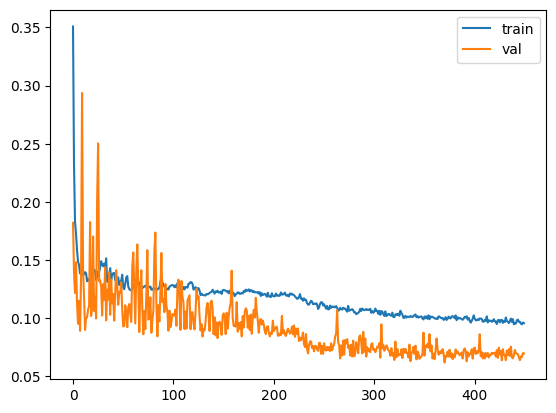

In [70]:
if args["load"] is None: # can remove this loop condition for future experiments since early stopping will also save all_train_loss and all_valid_loss quantities henceforth (Sep 24)
    plt.plot(all_train_loss, label="train")
    plt.plot(all_valid_loss, label="val")
    plt.legend()

In [71]:
train_data_eval = DataLoader(train_dataset, 
        batch_size = len(train_dataset),
        shuffle=False, 
        )

train_eval_batch = get_next_batch(inf_generator(train_data_eval))

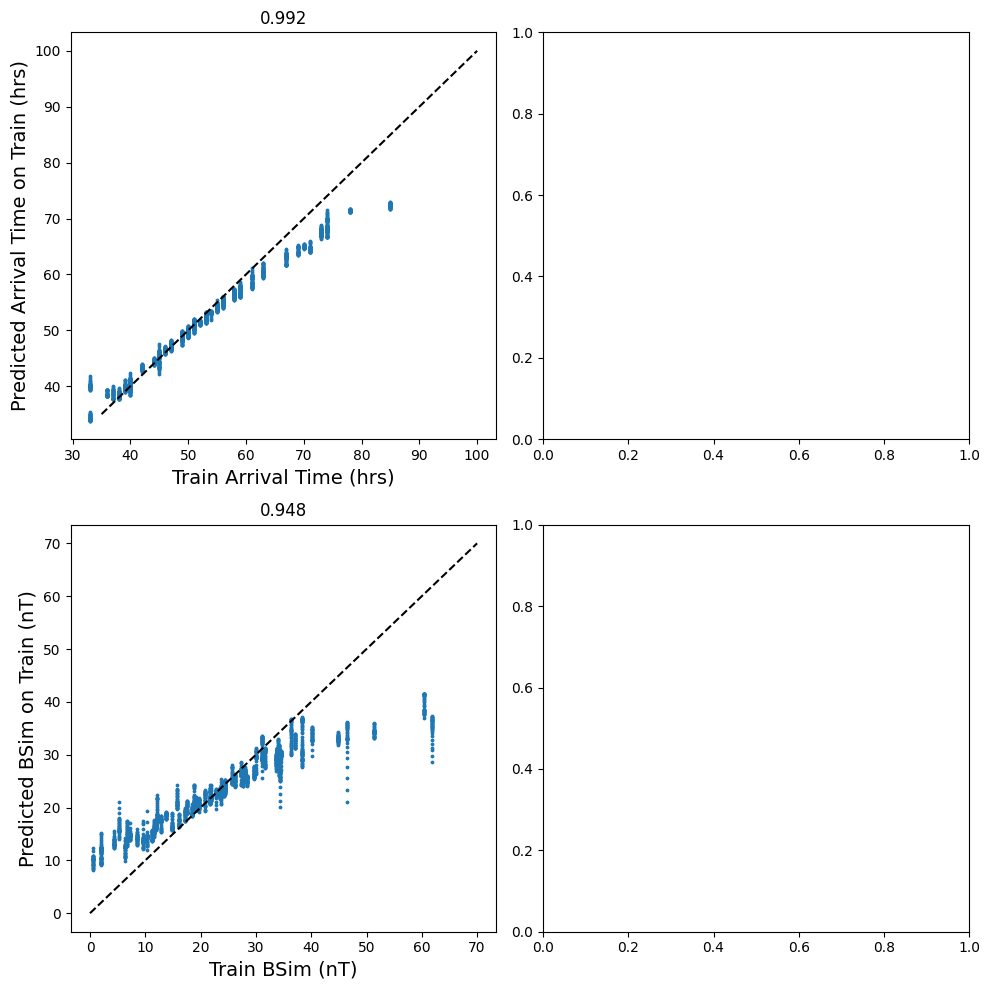

In [76]:
model.eval()
with torch.no_grad():
    train_preds_scaled = model(train_eval_batch[0]).cpu().numpy()

train_preds_unscaled = pt.inverse_transform(train_preds_scaled)
train_targets_all = train_eval_batch[2].squeeze(1).cpu().numpy()

train_preds_unscaled.shape, train_targets_all.shape

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(train_targets_all[:, 0], train_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[0, 0].set_xlabel("Train Arrival Time (hrs)", fontsize=14)
axs[0, 0].set_ylabel("Predicted Arrival Time on Train (hrs)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 0], train_preds_unscaled[:, 0])[0, 1]))

# axs[0, 1].scatter(train_targets_all[:, 1], train_preds_unscaled[:, 1], s=3)
# axs[0, 1].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
# axs[0, 1].set_xlabel("Train USim (km / s)", fontsize=14)
# axs[0, 1].set_ylabel("Predicted USim on Train (km / s)", fontsize=14)
# axs[0, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 1], train_preds_unscaled[:, 1])[0, 1]))

axs[1, 0].scatter(train_targets_all[:, 1], train_preds_unscaled[:, 1], s=3)
axs[1, 0].plot(np.linspace(0, 70, 40), np.linspace(0, 70, 40), '--', color='black')
axs[1, 0].set_xlabel("Train BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Train (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 1], train_preds_unscaled[:, 1])[0, 1]))

# axs[1, 1].scatter(train_targets_all[:, 3], train_preds_unscaled[:, 3], s=3)
# axs[1, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
# axs[1, 1].set_xlabel("Train NpSim (cm^-3)", fontsize=14)
# axs[1, 1].set_ylabel("Predicted NpSim on Train (cm^-3)", fontsize=14)
# axs[1, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 3], train_preds_unscaled[:, 3])[0, 1]))

plt.tight_layout()

(1026, 2) (1026, 2)


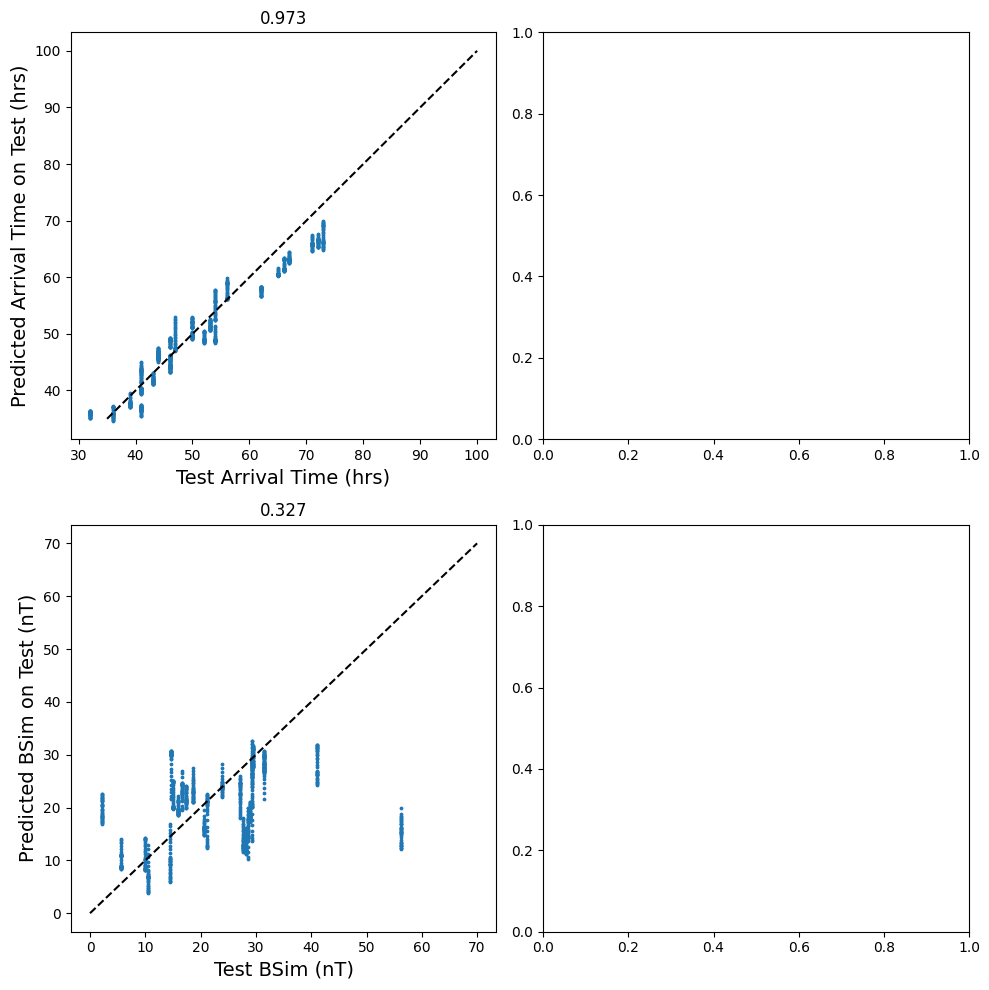

In [77]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
# true_test_arrs = pt.inverse_transform(test_data_all[1].cpu().numpy())
true_test_arrs = test_data_all[2].squeeze(1).cpu().numpy()
model.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()

test_preds_unscaled = pt.inverse_transform(test_preds)

print(test_preds_unscaled.shape, true_test_arrs.shape)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(true_test_arrs[:, 0], test_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[0, 0].set_xlabel("Test Arrival Time (hrs)", fontsize=14)
axs[0, 0].set_ylabel("Predicted Arrival Time on Test (hrs)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 0], test_preds_unscaled[:, 0])[0, 1]))

# axs[0, 1].scatter(true_test_arrs[:, 1], test_preds_unscaled[:, 1], s=3)
# axs[0, 1].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
# axs[0, 1].set_xlabel("Test USim (km / s)", fontsize=14)
# axs[0, 1].set_ylabel("Predicted USim on Test (km / s)", fontsize=14)
# axs[0, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled[:, 1])[0, 1]))

axs[1, 0].scatter(true_test_arrs[:, 1], test_preds_unscaled[:, 1], s=3)
axs[1, 0].plot(np.linspace(0, 70, 40), np.linspace(0, 70, 40), '--', color='black')
axs[1, 0].set_xlabel("Test BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Test (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled[:, 1])[0, 1]))

# axs[1, 1].scatter(true_test_arrs[:, 3], test_preds_unscaled[:, 3], s=3)
# axs[1, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
# axs[1, 1].set_xlabel("Test NpSim (cm^-3)", fontsize=14)
# axs[1, 1].set_ylabel("Predicted NpSim on Test (cm^-3)", fontsize=14)
# axs[1, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 3], test_preds_unscaled[:, 3])[0, 1]))

plt.tight_layout()

In [97]:
test_preds.shape

(1026, 2)

In [79]:
import argparse
import os
import cv2
import numpy as np
import torch
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise
)

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, RawScoresOutputTarget

In [98]:
class RegressionOutputTarget:
    def __init__(self, output_index=0):
        self.output_index = output_index

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.output_index]
        return model_output[:, self.output_index]

In [88]:
target_layers = [model.regressor[-1]]
input_tensor = test_data_all[0].to(device)
input_tensor.shape

torch.Size([1026, 1, 3, 1028])

In [99]:
# targets = [RawScoresOutputTarget()]
targets = [RegressionOutputTarget(output_index=0)]

In [100]:
cam_algorithm = GradCAM(model=model, target_layers=target_layers)

In [101]:
1026/32

32.0625

In [102]:
with cam_algorithm as cam:
    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        aug_smooth=True,
                        eigen_smooth=True,
                        )

    grayscale_cam = grayscale_cam[0, :]

    # cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    # cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

ValueError: Invalid grads shape.Shape of grads should be 4 (2D image) or 5 (3D image).